<a href="https://colab.research.google.com/github/Faisal-161/breast_cancer/blob/main/Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-optimize imbalanced-learn shap xgboost scikit-learn matplotlib seaborn pandas numpy scipy statsmodels



In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from google.colab import files # For downloading images
import warnings
warnings.filterwarnings('ignore')

# --- Data Loaders ---
def load_wdbc():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target)
    y = 1 - y # 1=Malignant
    return X, y, "WDBC (Morphological)"

def load_coimbra():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv"
    df = pd.read_csv(url)
    X = df.drop(columns=['Classification'])
    y = df['Classification']
    y = y.map({1: 0, 2: 1})
    return X, y, "Coimbra (Metabolic)"

def load_wbc_original():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
    columns = ['id', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape', 'marginal_adhesion', 'epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
    df = pd.read_csv(url, names=columns, na_values='?')
    df.dropna(inplace=True)
    X = df.drop(columns=['id', 'class'])
    y = df['class']
    y = y.map({2: 0, 4: 1})
    return X, y, "WBC Original (Cytological)"

# --- The Universal Engine ---
def evaluate_framework(X, y, dataset_name):
    print(f"\n{'='*100}")
    print(f"🚀 PROCESSING DATASET: {dataset_name}")
    print(f"   Samples: {X.shape[0]} | Features: {X.shape[1]}")
    print(f"   Class Balance: {sum(y==1)} Pos (Malignant) / {sum(y==0)} Neg (Benign)")
    print(f"{'='*100}")

    # A. Preprocessing
    if X.shape[1] > 10:
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
        X_filtered = X.drop(columns=to_drop)
        print(f"   Step 1: Removed {len(to_drop)} highly correlated features.")
    else:
        X_filtered = X
        print("   Step 1: Feature selection skipped (low dim).")

    # B. Optimization
    print("   Step 2: Optimizing models (Bayesian Search)...")
    k_best = min(14, X_filtered.shape[1])

    svm_space = {'model__C': Real(0.1, 50, prior='log-uniform'), 'model__gamma': Real(1e-4, 0.1, prior='log-uniform'), 'model__kernel': Categorical(['rbf'])}
    rf_space = {'model__n_estimators': Integer(100, 300), 'model__max_depth': Integer(5, 15)}
    xgb_space = {'model__learning_rate': Real(0.01, 0.2), 'model__n_estimators': Integer(100, 300)}

    def optimize(base, space):
        pipe = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(mutual_info_classif, k=k_best)),
            ('smote', SMOTE(random_state=42)),
            ('model', base)
        ])
        opt = BayesSearchCV(pipe, space, n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='accuracy')
        opt.fit(X_filtered, y)
        return opt.best_estimator_

    best_svm = optimize(SVC(probability=True, kernel='rbf'), svm_space)
    best_rf = optimize(RandomForestClassifier(random_state=42), rf_space)
    best_xgb = optimize(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_space)

    # C. Ensemble
    ensemble_model = VotingClassifier(
        estimators=[('svm', best_svm), ('rf', best_rf), ('xgb', best_xgb)],
        voting='soft'
    )

    # D. Rigorous Validation
    print("   Step 3: Running 100-Fold Comparative Validation...")
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
    models = {"SVM": best_svm, "Random Forest": best_rf, "XGBoost": best_xgb, "Hybrid Ensemble": ensemble_model}

    results_data = []
    cv_scores = {}
    cv_preds = {}

    for name, model in models.items():
        # Scores
        scores = cross_val_score(model, X_filtered, y, scoring='accuracy', cv=cv, n_jobs=-1)
        cv_scores[name] = scores

        # Predictions
        preds = cross_val_predict(model, X_filtered, y, cv=10, n_jobs=-1)
        cv_preds[name] = preds

        # Probabilities
        probas = cross_val_predict(model, X_filtered, y, cv=10, method='predict_proba', n_jobs=-1)[:, 1]

        # Metrics
        tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
        results_data.append({
            "Model": name,
            "Accuracy": scores.mean() * 100,
            "Stability": scores.std() * 100,
            "Sensitivity": recall_score(y, preds) * 100,
            "Specificity": (tn / (tn + fp)) * 100,
            "AUC": roc_auc_score(y, probas),
            "MCC": matthews_corrcoef(y, preds),
            "F1": f1_score(y, preds)
        })

    # --- E. Performance Table ---
    results_df = pd.DataFrame(results_data)
    print(f"\n📊 METRICS FOR {dataset_name}:")
    print(results_df[['Model', 'Accuracy', 'Stability', 'F1', 'AUC', 'MCC']].round(4).to_markdown(index=False))

    # --- F. Statistical Tests ---
    print("\n   🔬 STATISTICAL HYPOTHESIS TESTING (Ensemble vs Others)")
    print(f"   {'Comparison':<30} | {'Wilcoxon p':<15} | {'T-Test p':<15} | {'McNemar p':<15}")
    print("-" * 80)

    ens_scores = cv_scores["Hybrid Ensemble"]
    ens_preds = cv_preds["Hybrid Ensemble"]

    def fmt(p):
        if p < 0.001: return "*** (<.001)"
        if p < 0.05: return f"*   ({p:.4f})"
        return f"ns  ({p:.4f})"

    for base in ["SVM", "Random Forest", "XGBoost"]:
        base_scores = cv_scores[base]
        base_preds = cv_preds[base]

        _, w_p = stats.wilcoxon(ens_scores, base_scores)
        _, t_p = stats.ttest_rel(ens_scores, base_scores)

        correct_ens = (ens_preds == y)
        correct_base = (base_preds == y)
        b = sum(correct_ens & ~correct_base)
        c = sum(~correct_ens & correct_base)
        table = [[sum(correct_ens & correct_base), c], [b, sum(~correct_ens & ~correct_base)]]
        mc_res = mcnemar(table, exact=True)

        print(f"   vs {base:<27} | {fmt(w_p):<15} | {fmt(t_p):<15} | {fmt(mc_res.pvalue):<15}")

    # --- G. ROC Plot ---
    plt.figure(figsize=(6, 5))
    colors = {"SVM": "green", "Random Forest": "orange", "XGBoost": "blue", "Hybrid Ensemble": "red"}
    styles = {"SVM": "--", "Random Forest": "--", "XGBoost": "--", "Hybrid Ensemble": "-"}
    widths = {"SVM": 1, "Random Forest": 1, "XGBoost": 1, "Hybrid Ensemble": 2.5}

    for name, model in models.items():
        probas = cross_val_predict(model, X_filtered, y, cv=10, method='predict_proba', n_jobs=-1)[:, 1]
        fpr, tpr, _ = roc_curve(y, probas)
        auc_val = roc_auc_score(y, probas)
        plt.plot(fpr, tpr, color=colors[name], linestyle=styles[name], lw=widths[name], label=f'{name} (AUC={auc_val:.3f})')

    plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
    plt.title(f'Comparative ROC: {dataset_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # --- H. Confusion Matrix (Hybrid Ensemble) ---
    print(f"\n   generating Confusion Matrix for {dataset_name}...")
    cm = confusion_matrix(y, ens_preds)

    plt.figure(figsize=(5, 4), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={"size": 12, "weight": "bold"},
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix: {dataset_name}", fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=10, fontweight='bold')
    plt.ylabel('Actual', fontsize=10, fontweight='bold')

    safe_name = dataset_name.replace(" ", "_").replace("(", "").replace(")", "")
    plt.savefig(f"CM_{safe_name}.png", dpi=300, bbox_inches='tight')
    files.download(f"CM_{safe_name}.png")
    plt.show()

    # --- I. SHAP Analysis (Hybrid Ensemble) ---
    print(f"\n   Generating SHAP Plot for {dataset_name}...")
    try:
        # Use KernelExplainer for the Ensemble (Slow, so we summarize data)
        # 1. Fit the ensemble on the whole dataset
        ensemble_model.fit(X_filtered, y)

        # 2. Define prediction wrapper
        def model_predict(data):
            # Ensure input is DataFrame
            if isinstance(data, np.ndarray):
                data = pd.DataFrame(data, columns=X_filtered.columns)
            return ensemble_model.predict_proba(data)[:, 1]

        # 3. Create Background (Summary)
        # Using 20 samples for background to keep speed reasonable
        background = shap.kmeans(X_filtered, 20)

        # 4. Explainer
        explainer = shap.KernelExplainer(model_predict, background)

        # 5. Calculate SHAP values (subset of data for speed)
        # We take a sample of 100 rows to explain
        sample_data = X_filtered.sample(min(100, len(X_filtered)), random_state=42)
        shap_values = explainer.shap_values(sample_data, nsamples=100)

        # 6. Plot
        plt.figure(figsize=(8, 6), dpi=300)
        plt.title(f"SHAP Importance: {dataset_name}", fontsize=12, fontweight='bold')
        shap.summary_plot(shap_values, sample_data, show=False)
        plt.tight_layout()
        plt.savefig(f"SHAP_{safe_name}.png", dpi=300, bbox_inches='tight')
        files.download(f"SHAP_{safe_name}.png")
        plt.show()

    except Exception as e:
        print(f"⚠️ SHAP generation skipped due to error: {e}")

    return results_df

# Define global list for final summary
final_summary_data = []


🚀 PROCESSING DATASET: WDBC (Morphological)
   Samples: 569 | Features: 30
   Class Balance: 212 Pos (Malignant) / 357 Neg (Benign)
   Step 1: Removed 10 highly correlated features.
   Step 2: Optimizing models (Bayesian Search)...
   Step 3: Running 100-Fold Comparative Validation...

📊 METRICS FOR WDBC (Morphological):
| Model           |   Accuracy |   Stability |     F1 |    AUC |    MCC |
|:----------------|-----------:|------------:|-------:|-------:|-------:|
| SVM             |    97.1698 |      2.2071 | 0.9691 | 0.9951 | 0.9511 |
| Random Forest   |    95.9749 |      2.519  | 0.9454 | 0.9908 | 0.9134 |
| XGBoost         |    96.2043 |      2.5332 | 0.9551 | 0.99   | 0.9285 |
| Hybrid Ensemble |    97.0999 |      2.1028 | 0.9645 | 0.9938 | 0.9436 |

   🔬 STATISTICAL HYPOTHESIS TESTING (Ensemble vs Others)
   Comparison                     | Wilcoxon p      | T-Test p        | McNemar p      
--------------------------------------------------------------------------------
   vs 

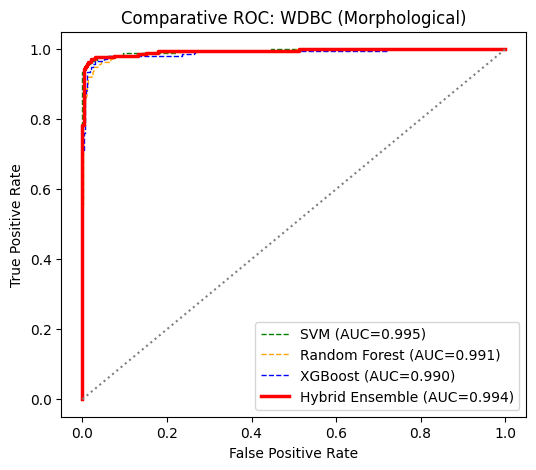


   generating Confusion Matrix for WDBC (Morphological)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

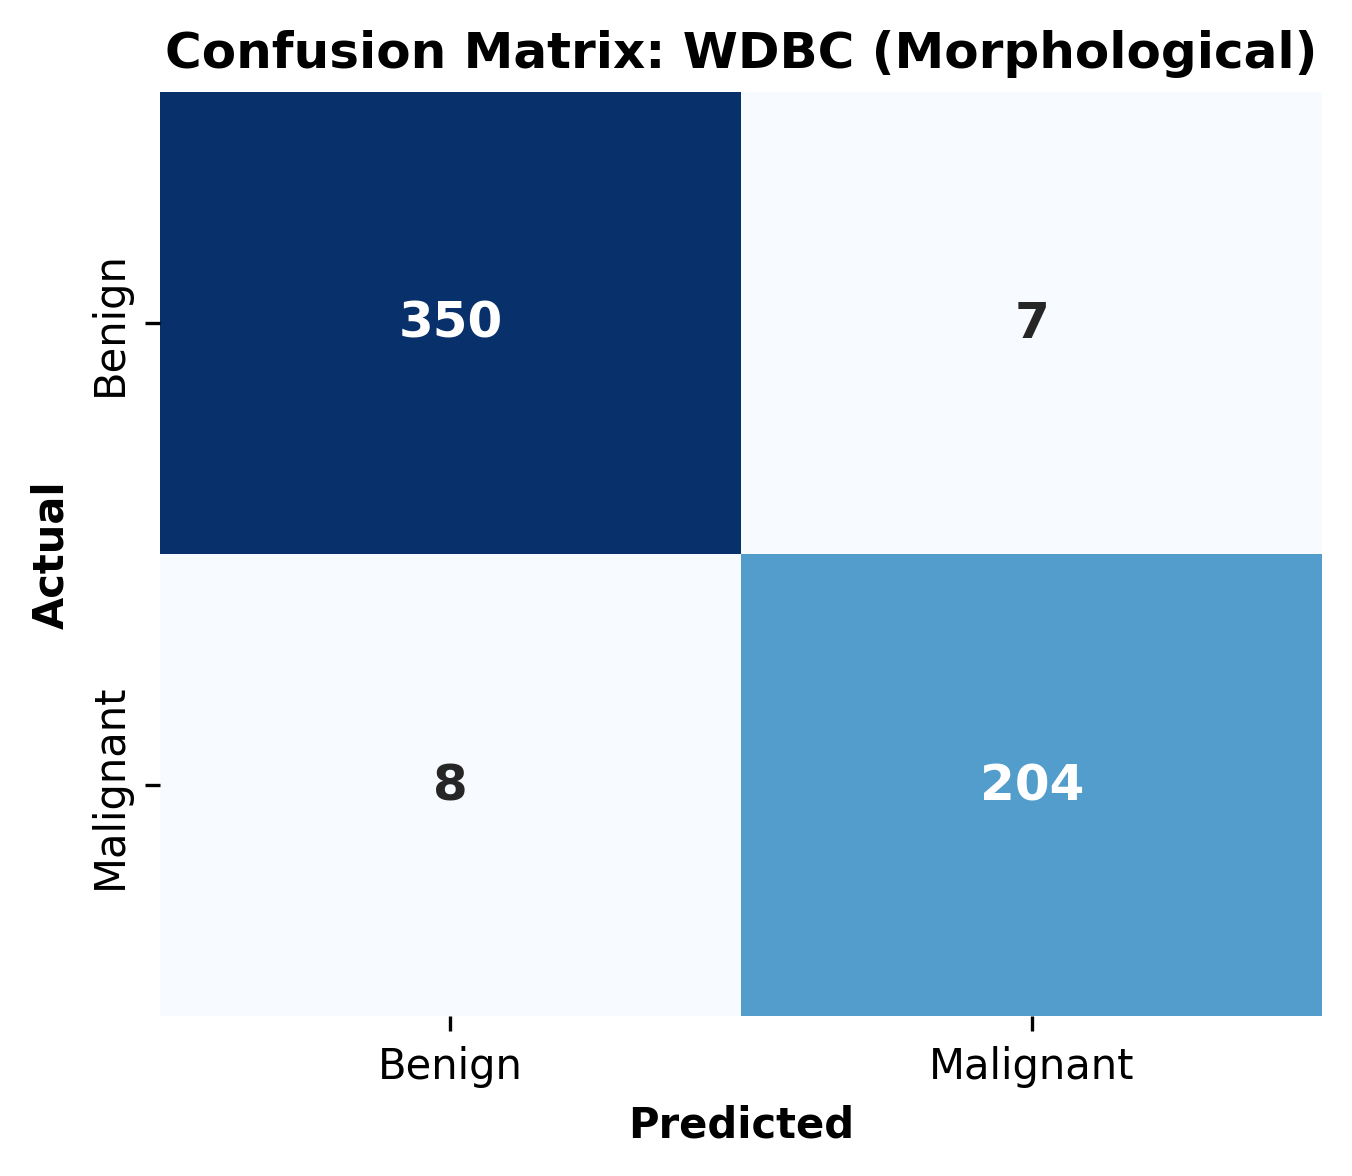


   Generating SHAP Plot for WDBC (Morphological)...


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

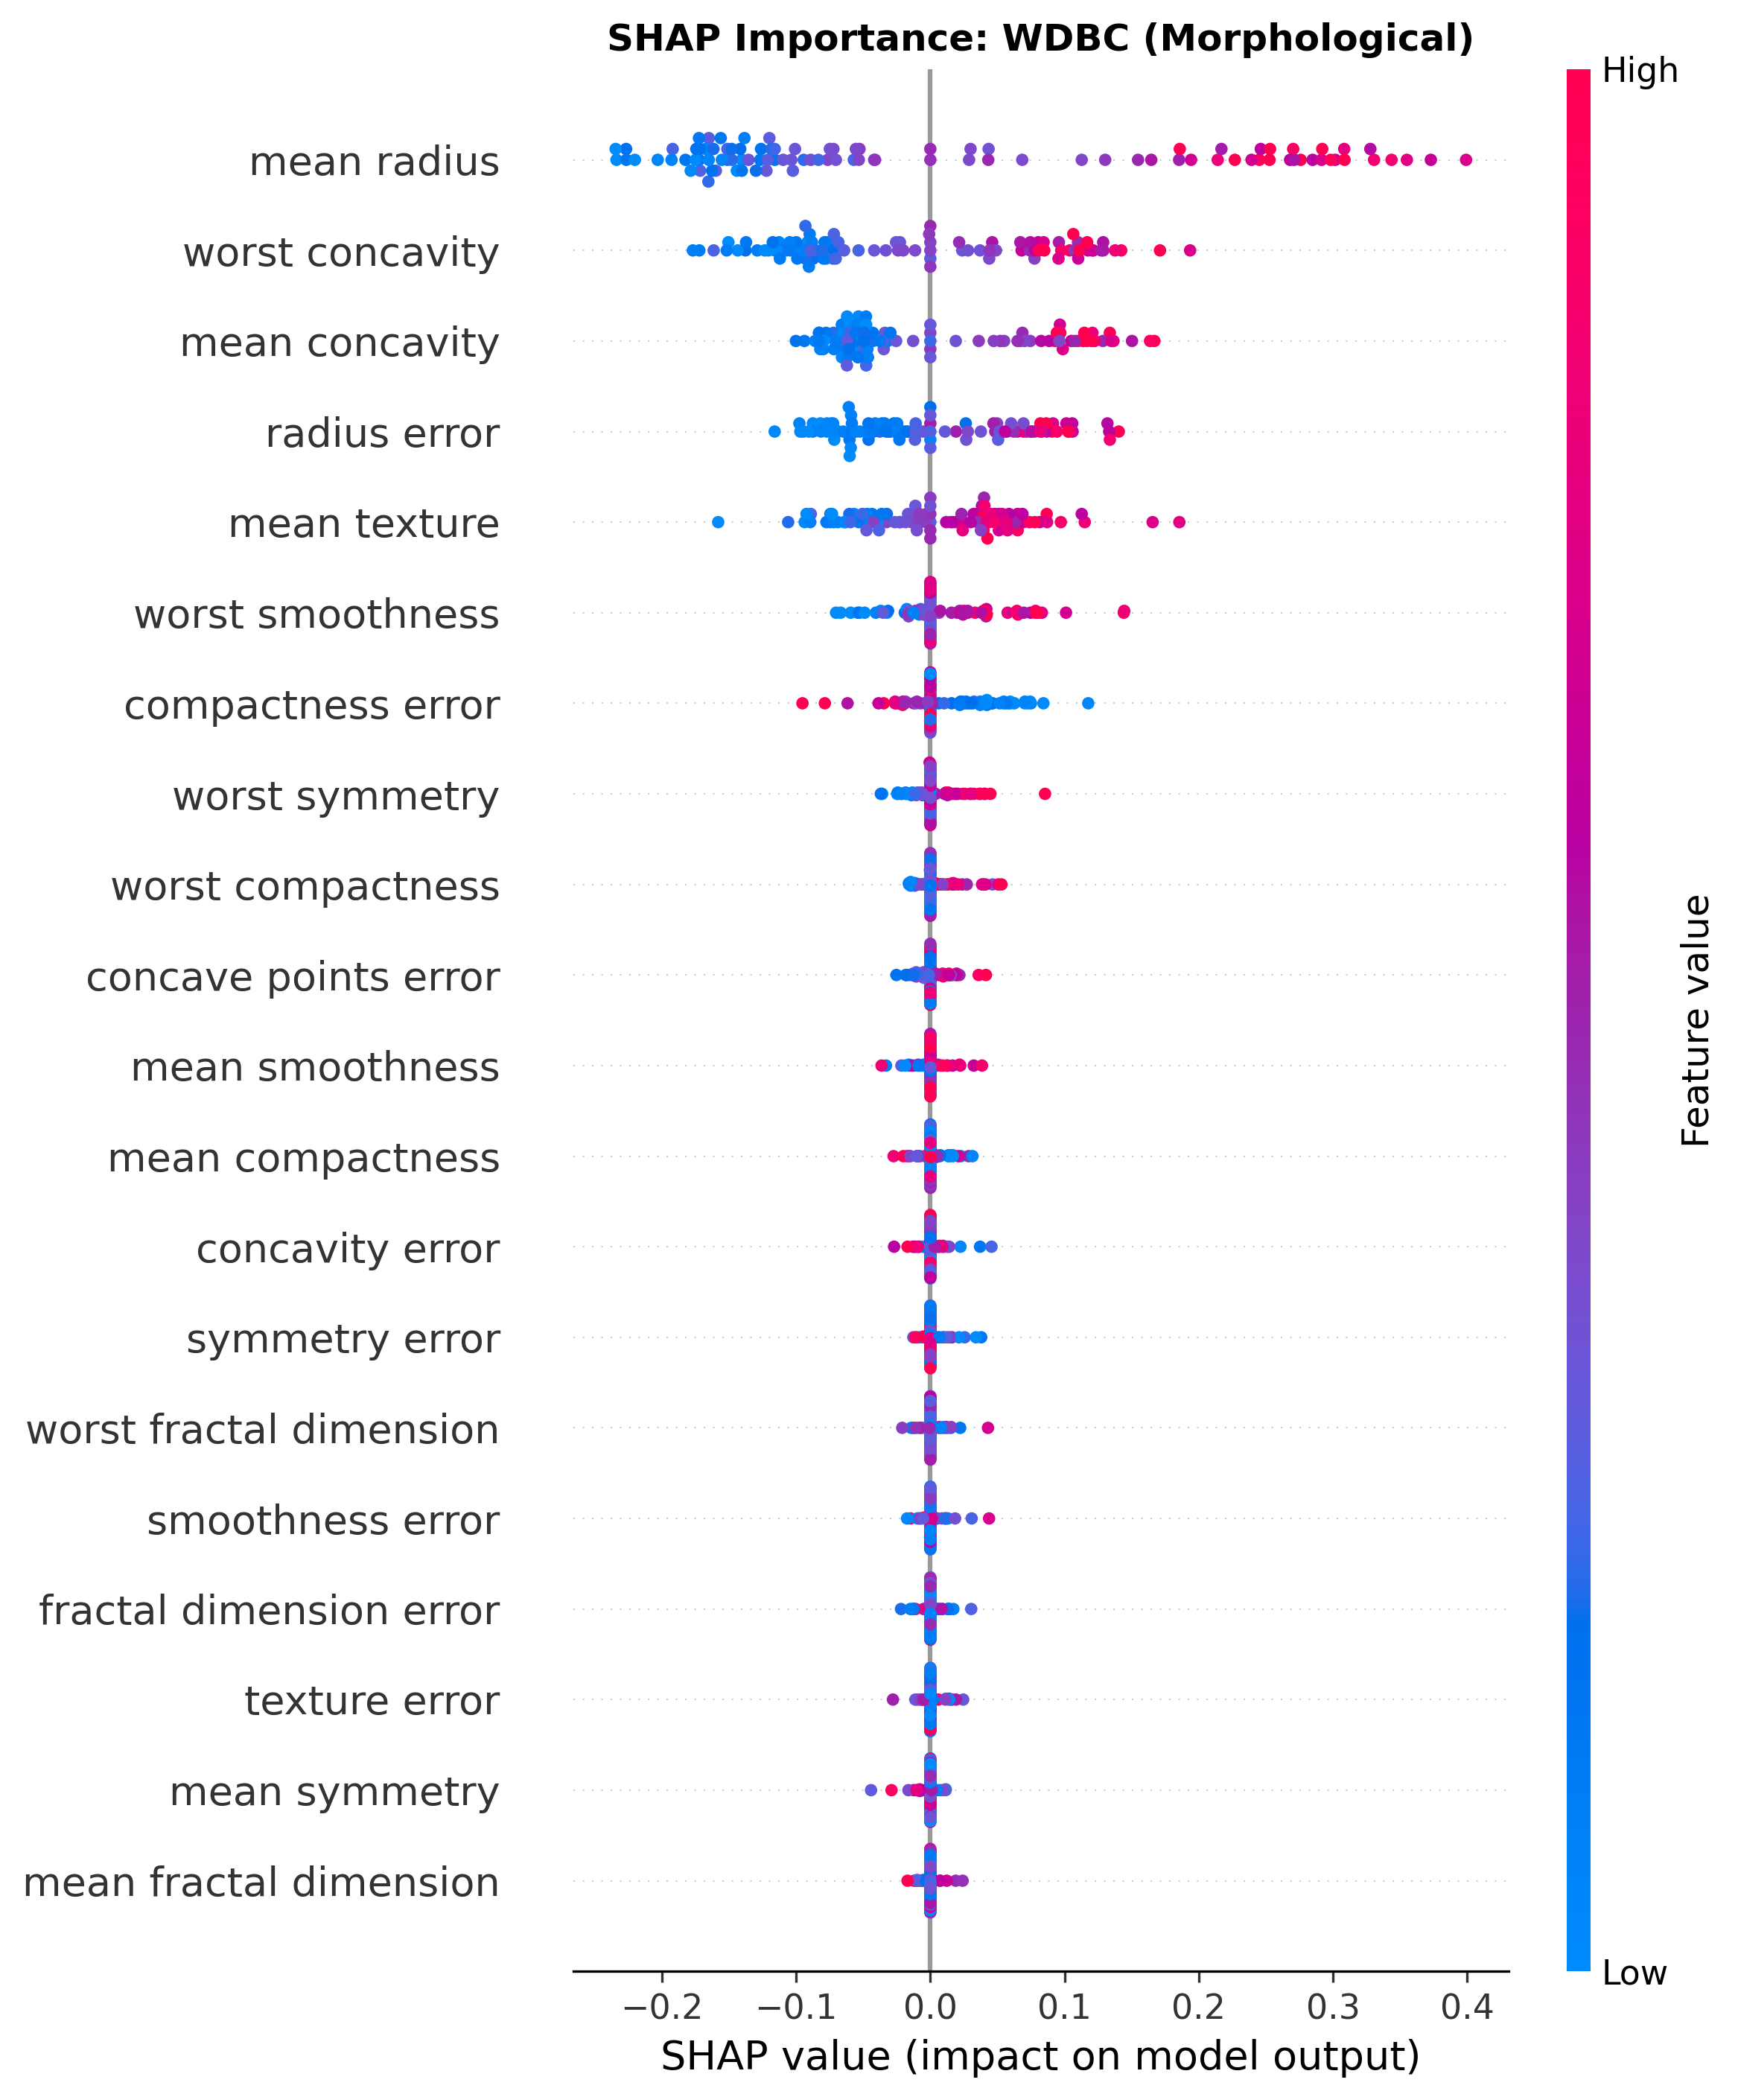

In [ ]:
# --- 1. Evaluate WDBC ---
data1 = load_wdbc()
df_wdbc = evaluate_framework(data1[0], data1[1], data1[2])

# Extract Ensemble row for final summary
row = df_wdbc[df_wdbc['Model'] == 'Hybrid Ensemble'].iloc[0].to_dict()
row['Dataset'] = 'WDBC (Morphological)'
final_summary_data.append(row)


🚀 PROCESSING DATASET: Coimbra (Metabolic)
   Samples: 116 | Features: 9
   Class Balance: 64 Pos (Malignant) / 52 Neg (Benign)
   Step 1: Feature selection skipped (low dim).
   Step 2: Optimizing models (Bayesian Search)...
   Step 3: Running 100-Fold Comparative Validation...

📊 METRICS FOR Coimbra (Metabolic):
| Model           |   Accuracy |   Stability |     F1 |    AUC |    MCC |
|:----------------|-----------:|------------:|-------:|-------:|-------:|
| SVM             |    75.0833 |     13.5248 | 0.7107 | 0.7581 | 0.4005 |
| Random Forest   |    71.6667 |     13.1299 | 0.7556 | 0.7831 | 0.4208 |
| XGBoost         |    71.4167 |     14.001  | 0.7442 | 0.7641 | 0.4239 |
| Hybrid Ensemble |    73.8636 |     13.4514 | 0.7656 | 0.8035 | 0.4772 |

   🔬 STATISTICAL HYPOTHESIS TESTING (Ensemble vs Others)
   Comparison                     | Wilcoxon p      | T-Test p        | McNemar p      
--------------------------------------------------------------------------------
   vs SVM    

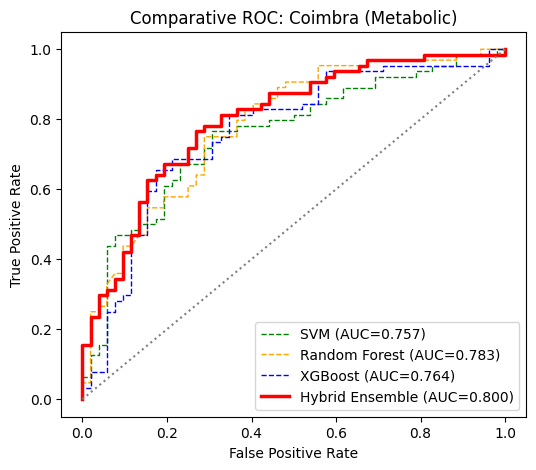


   generating Confusion Matrix for Coimbra (Metabolic)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

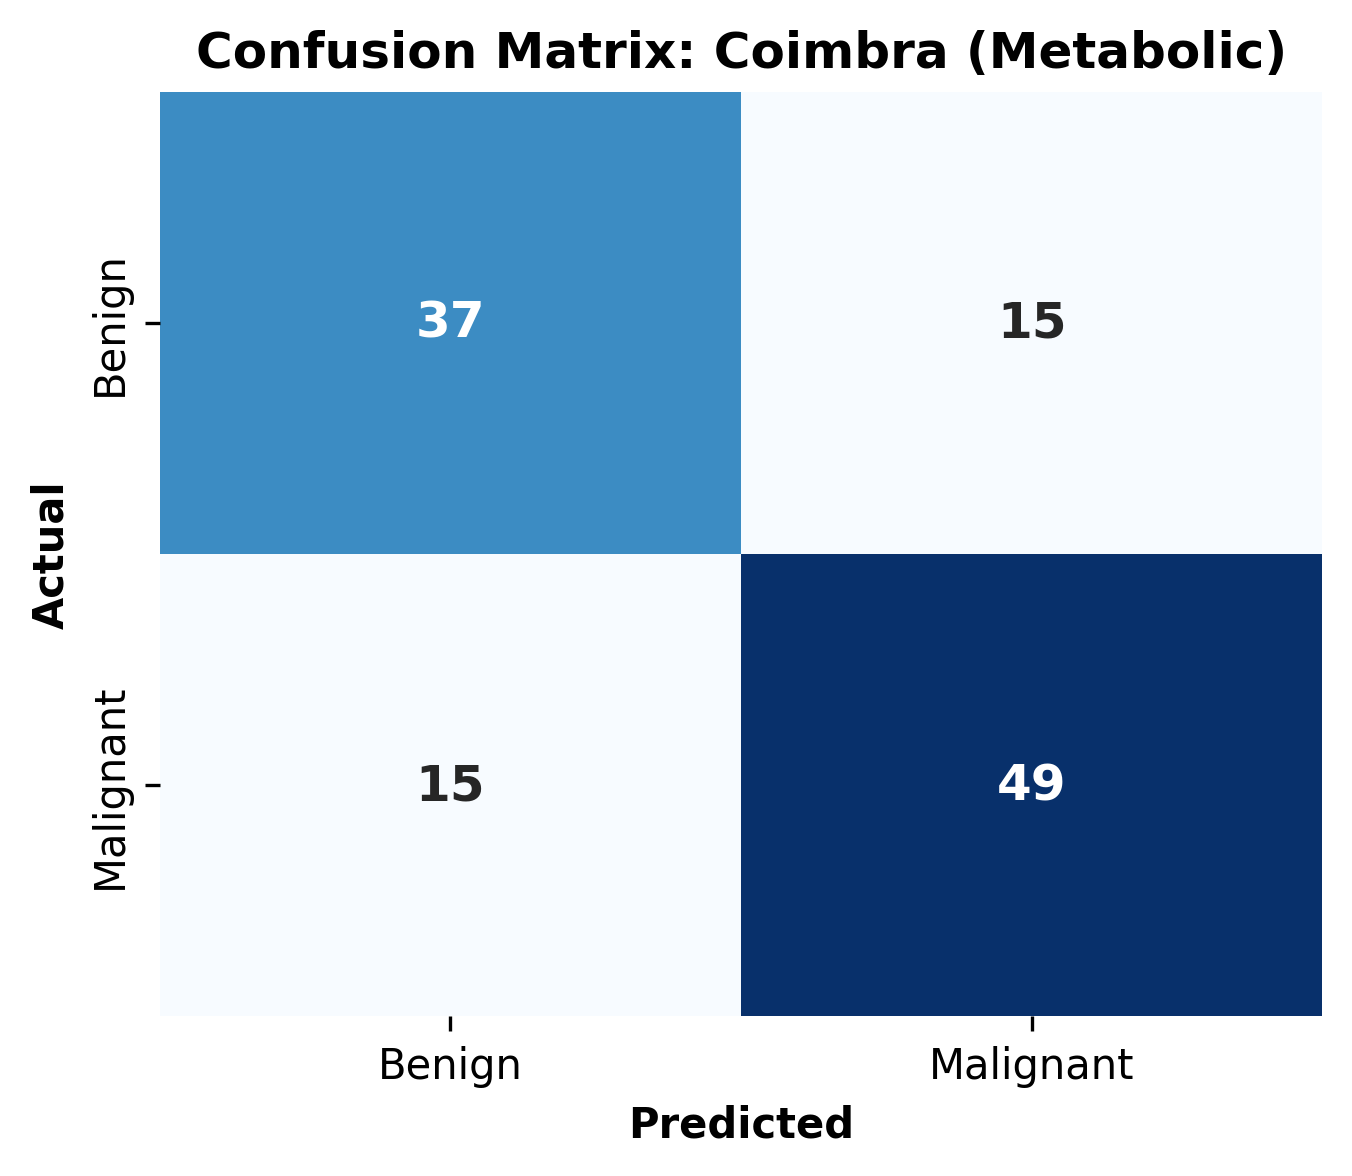


   Generating SHAP Plot for Coimbra (Metabolic)...


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

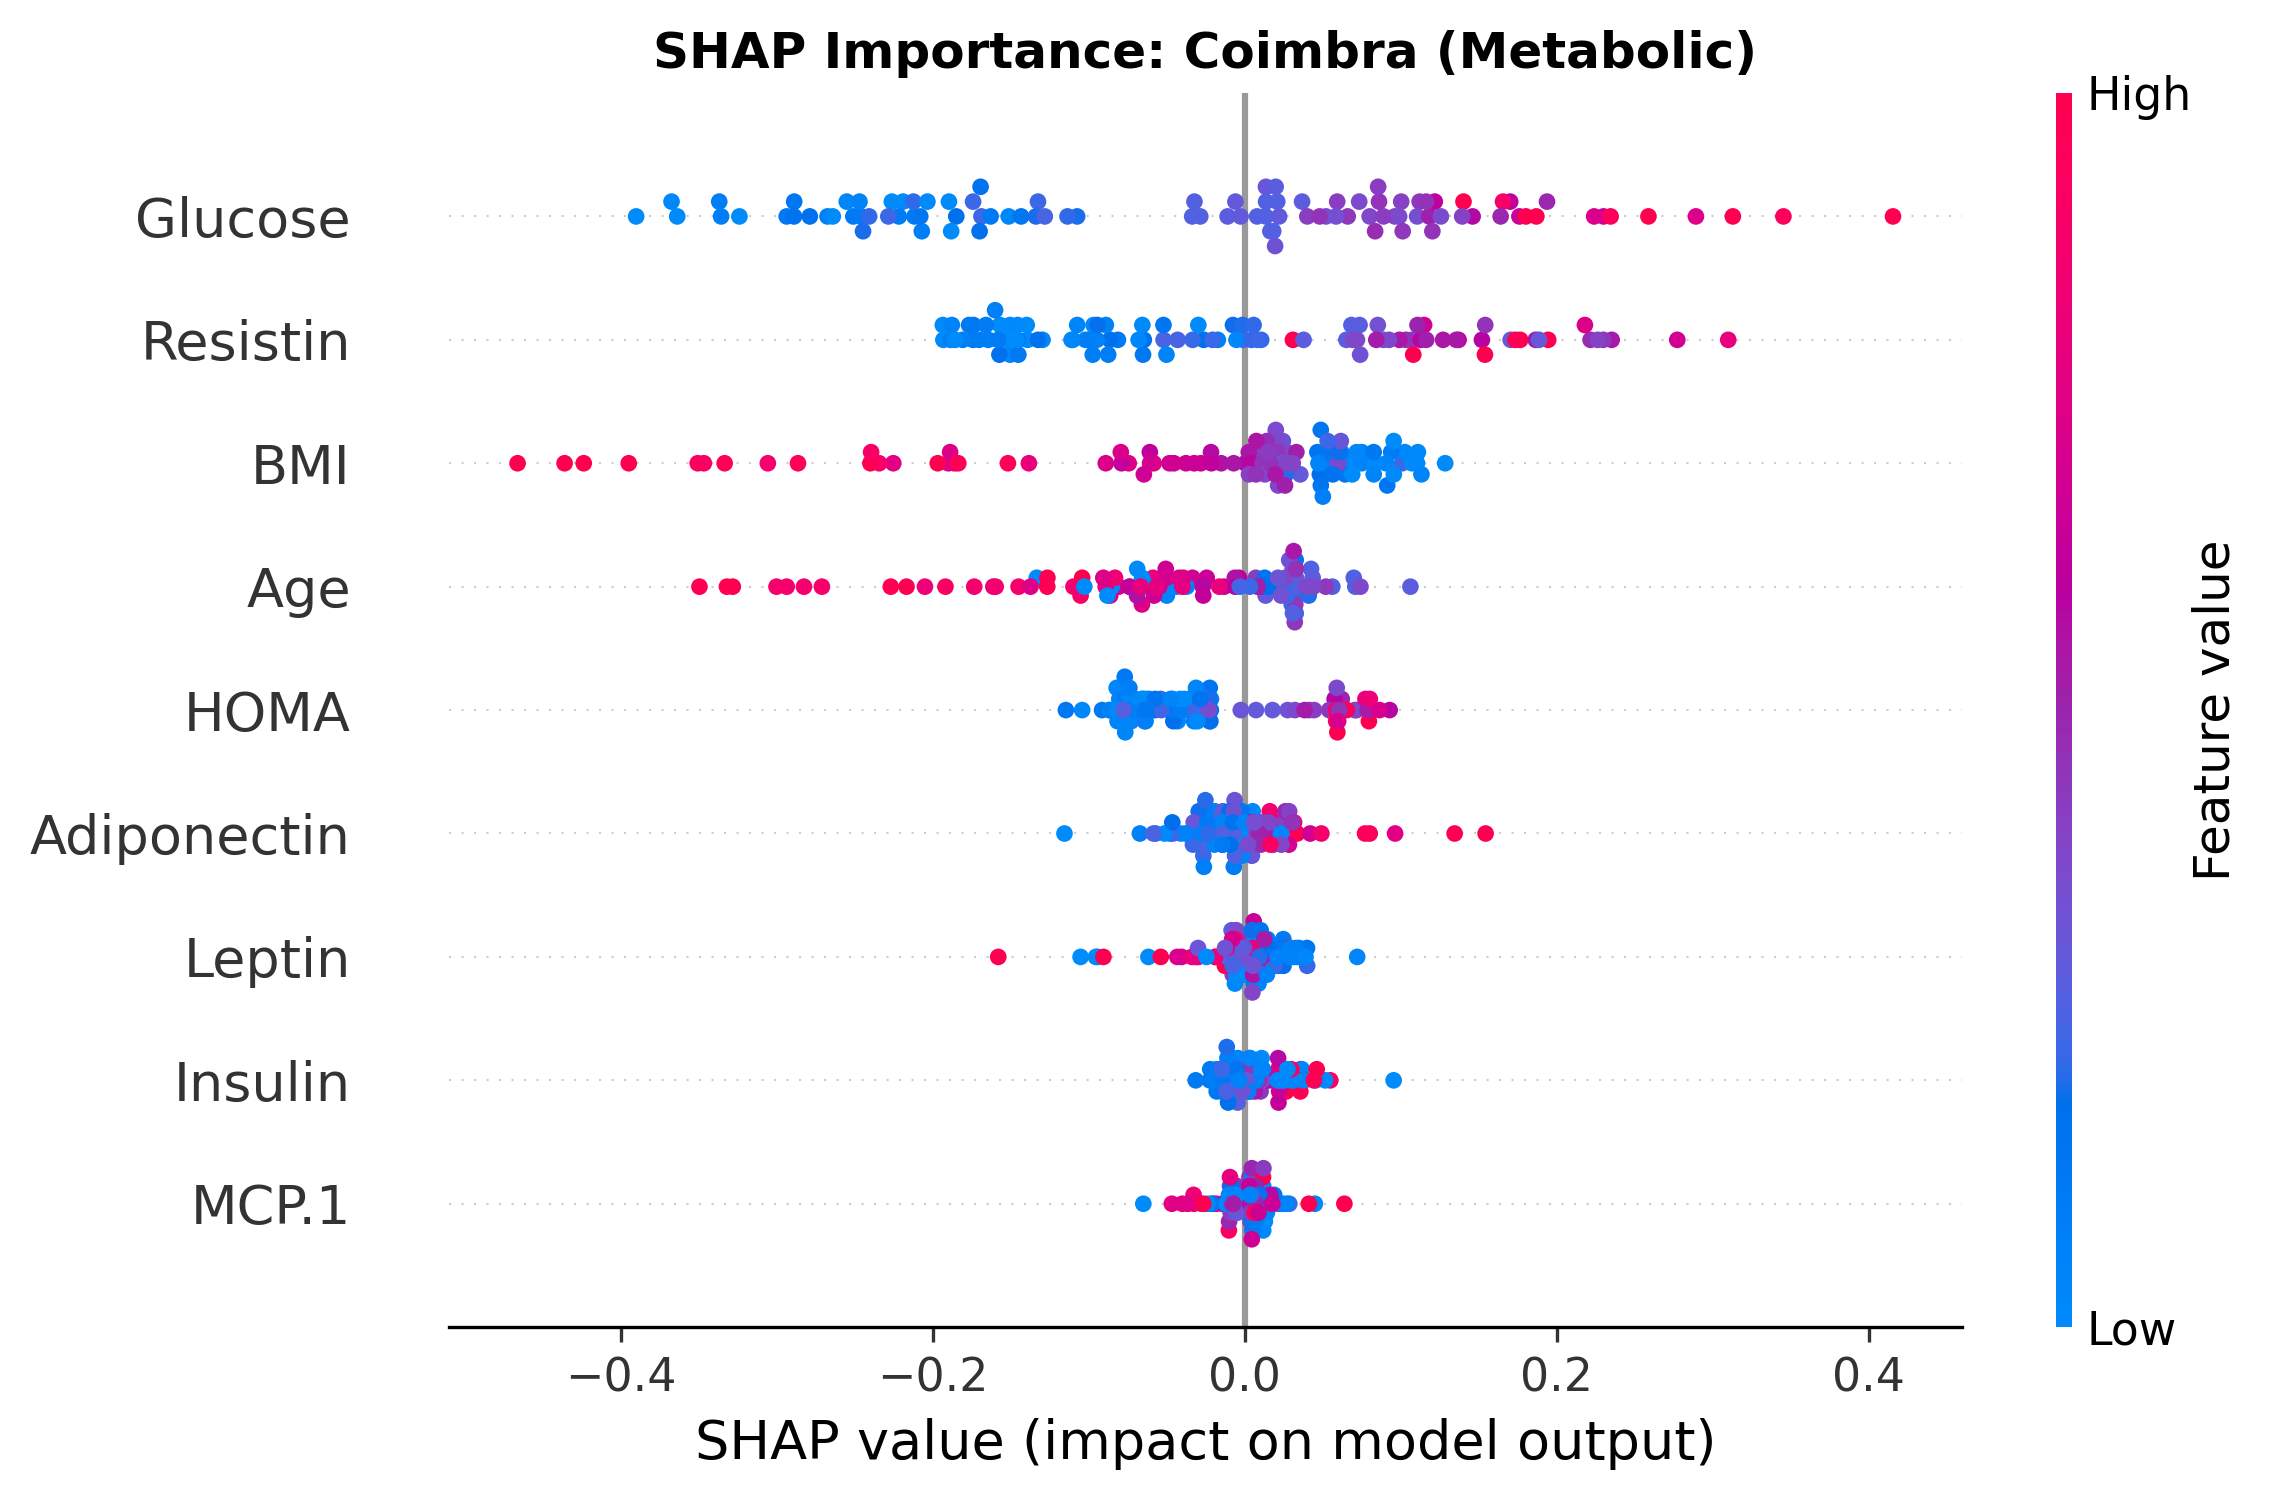

In [ ]:
# --- 2. Evaluate Coimbra ---
data2 = load_coimbra()
df_coimbra = evaluate_framework(data2[0], data2[1], data2[2])

# Extract Ensemble row for final summary
row = df_coimbra[df_coimbra['Model'] == 'Hybrid Ensemble'].iloc[0].to_dict()
row['Dataset'] = 'Coimbra (Metabolic)'
final_summary_data.append(row)


🚀 PROCESSING DATASET: WBC Original (Cytological)
   Samples: 683 | Features: 9
   Class Balance: 239 Pos (Malignant) / 444 Neg (Benign)
   Step 1: Feature selection skipped (low dim).
   Step 2: Optimizing models (Bayesian Search)...
   Step 3: Running 100-Fold Comparative Validation...

📊 METRICS FOR WBC Original (Cytological):
| Model           |   Accuracy |   Stability |     F1 |    AUC |    MCC |
|:----------------|-----------:|------------:|-------:|-------:|-------:|
| SVM             |    97.1147 |      1.7552 | 0.9608 | 0.9944 | 0.9395 |
| Random Forest   |    97.2607 |      1.7081 | 0.9607 | 0.9915 | 0.9393 |
| XGBoost         |    96.5865 |      1.9572 | 0.9417 | 0.9892 | 0.9101 |
| Hybrid Ensemble |    97.3188 |      1.5414 | 0.9542 | 0.9922 | 0.9294 |

   🔬 STATISTICAL HYPOTHESIS TESTING (Ensemble vs Others)
   Comparison                     | Wilcoxon p      | T-Test p        | McNemar p      
------------------------------------------------------------------------------

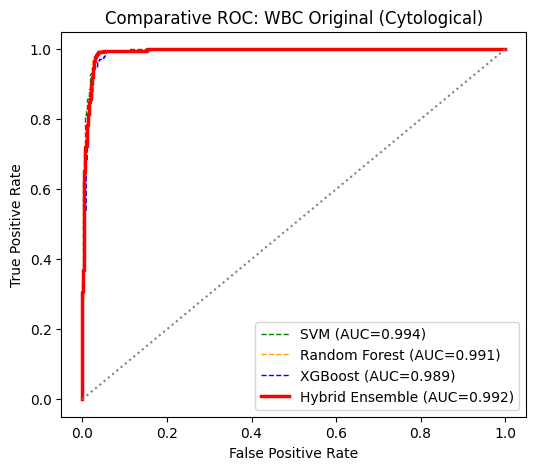


   generating Confusion Matrix for WBC Original (Cytological)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

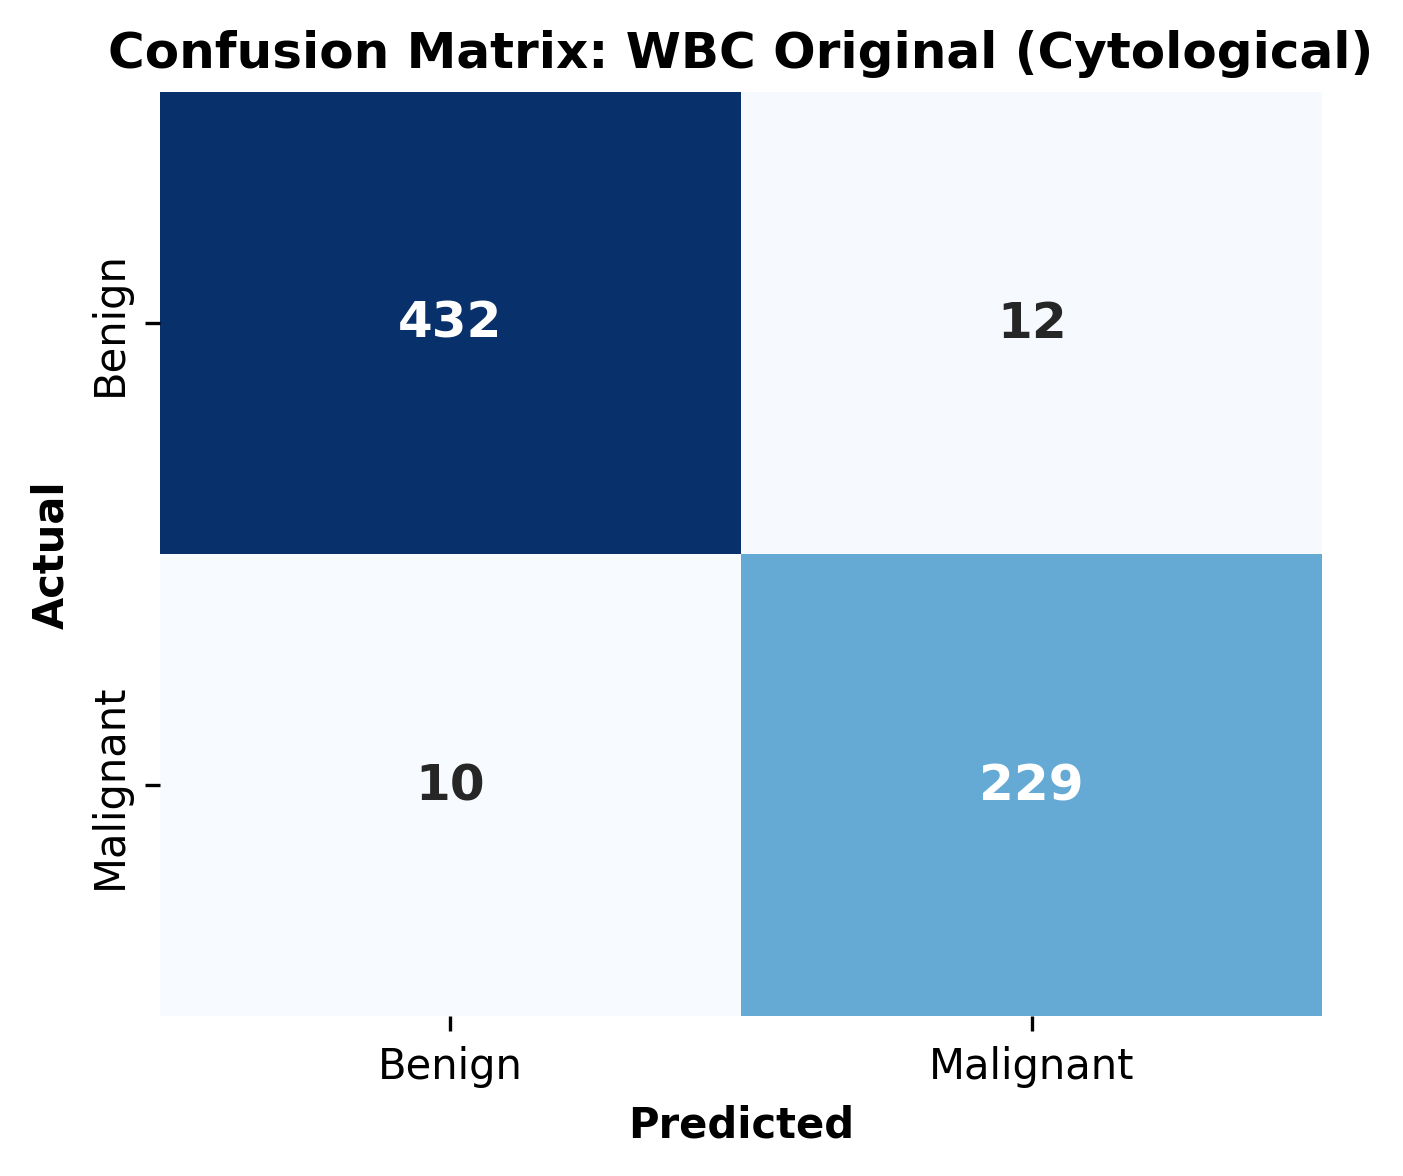


   Generating SHAP Plot for WBC Original (Cytological)...


  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

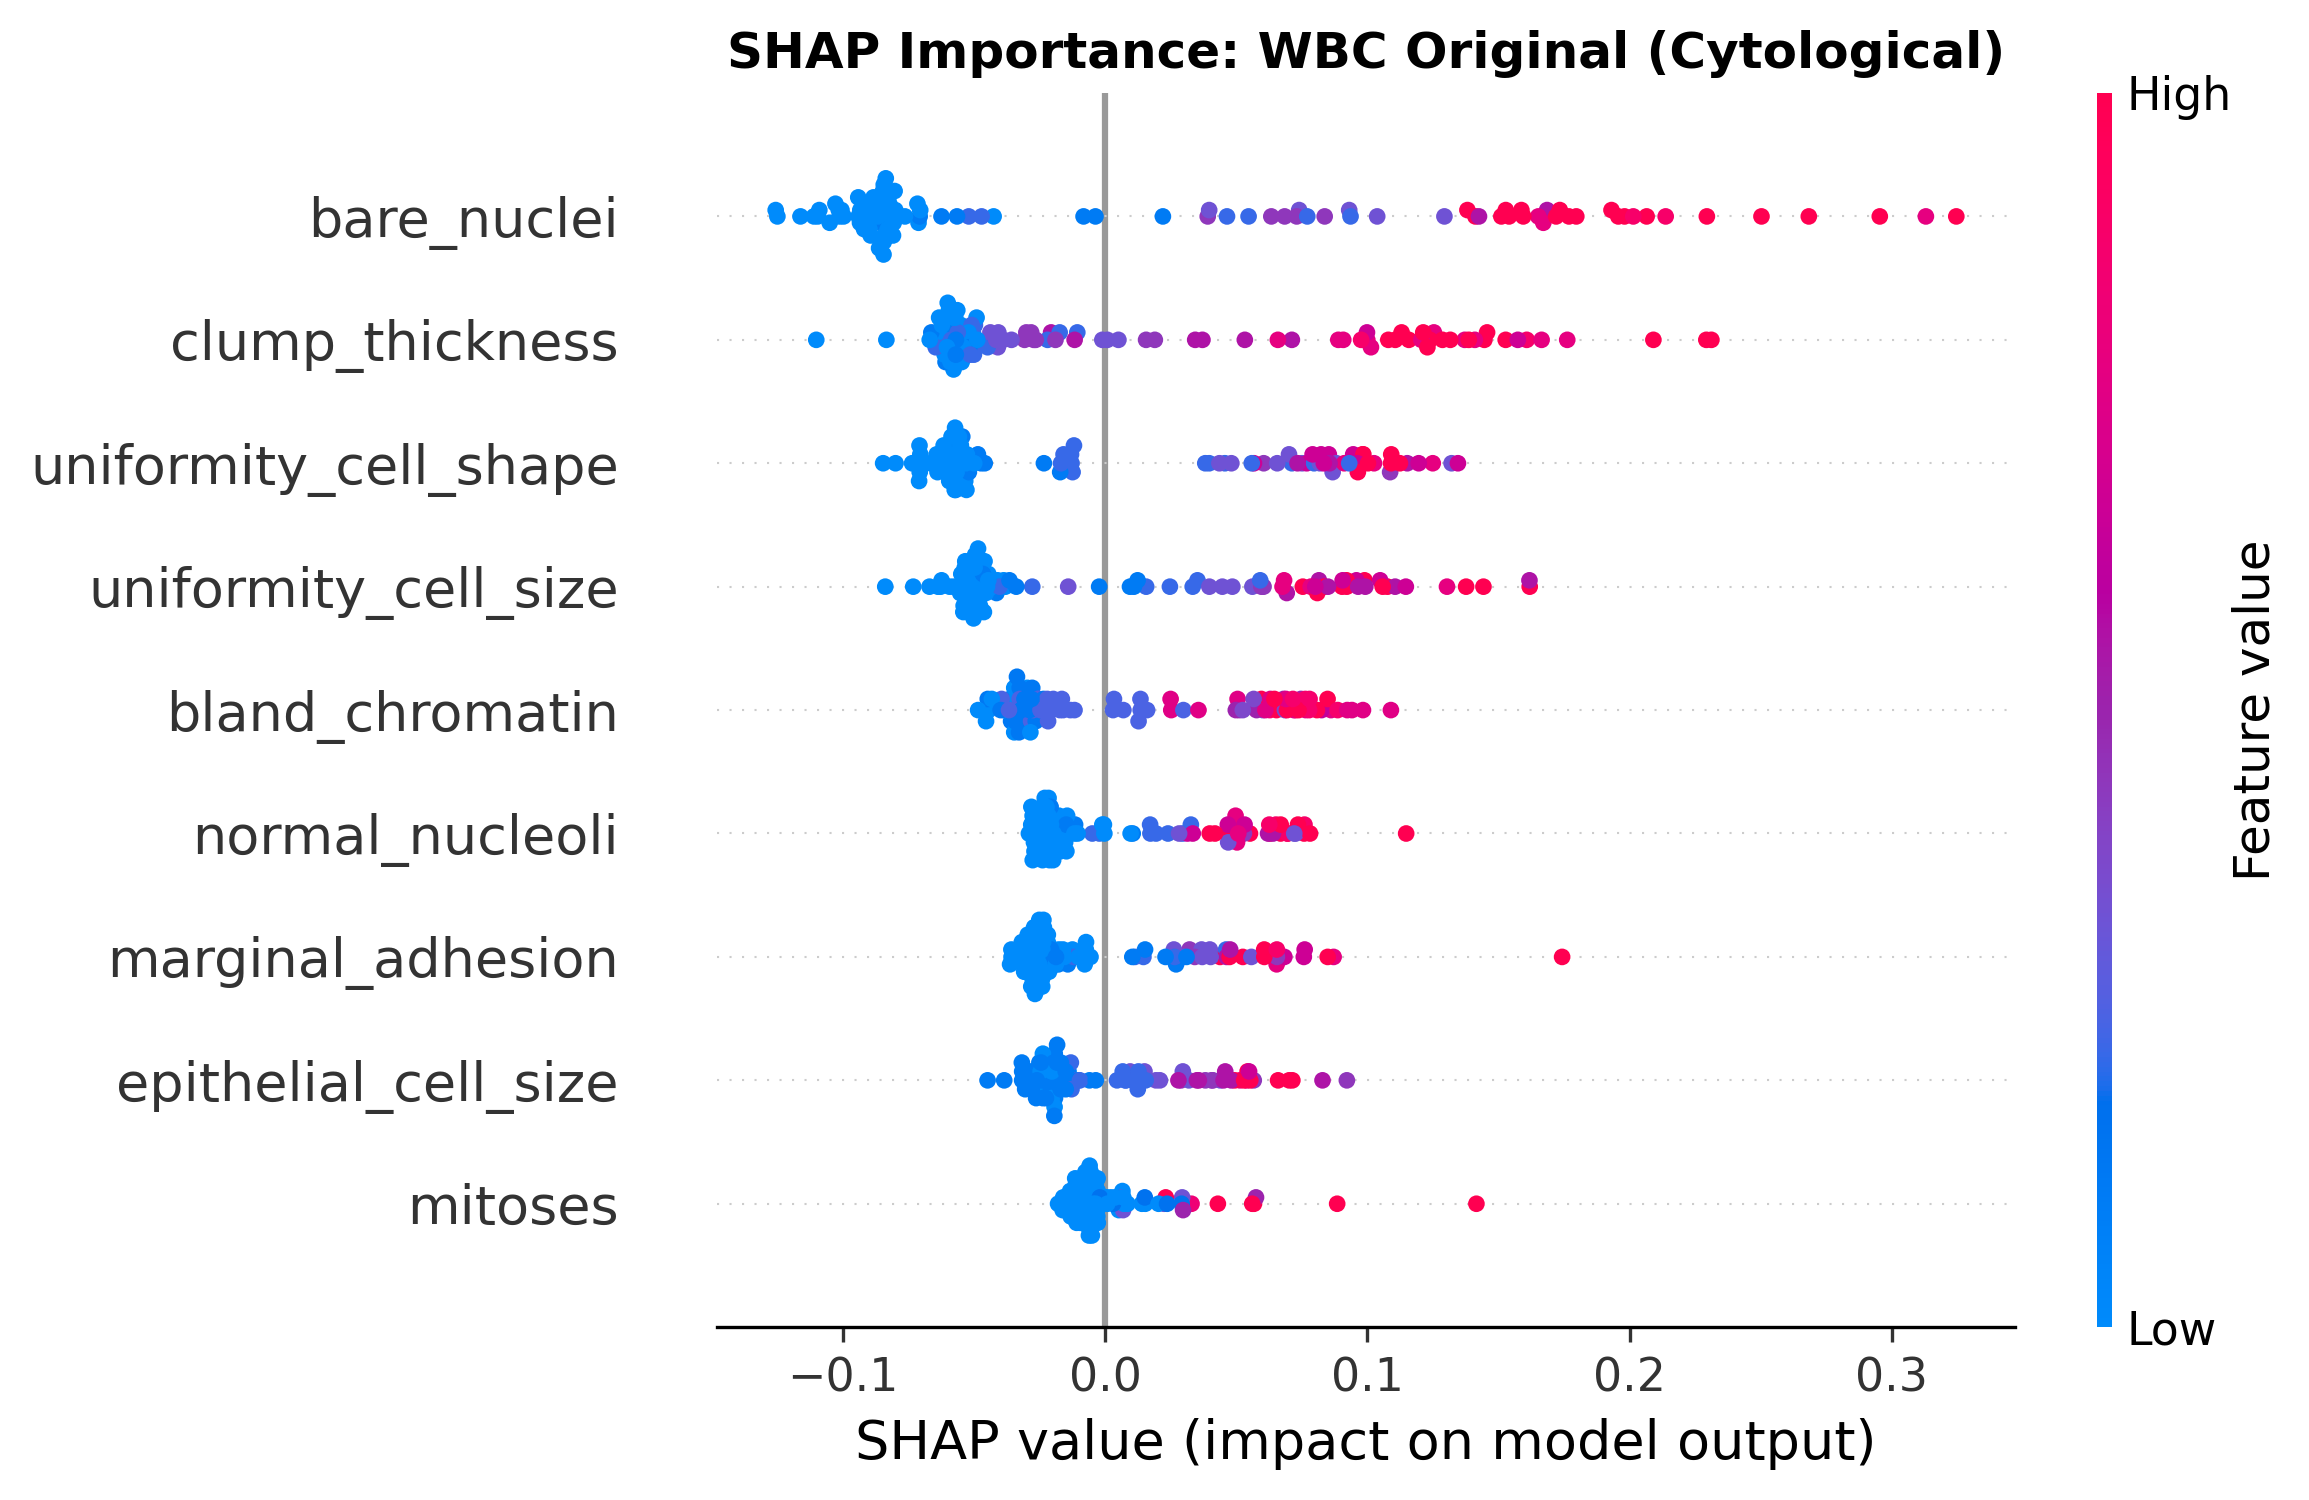


   FINAL CROSS-DATASET EVALUATION TABLE (Hybrid Ensemble Performance)
   (Copy these numbers into your 'Cross-Dataset Evaluation' LaTeX table)
| Dataset                    |   Accuracy |   Stability |   Sensitivity |   Specificity |    AUC |    MCC |
|:---------------------------|-----------:|------------:|--------------:|--------------:|-------:|-------:|
| WDBC (Morphological)       |    97.0999 |      2.1028 |       96.2264 |       98.0392 | 0.9938 | 0.9436 |
| Coimbra (Metabolic)        |    73.8636 |     13.4514 |       76.5625 |       71.1538 | 0.8035 | 0.4772 |
| WBC Original (Cytological) |    97.3188 |      1.5414 |       95.8159 |       97.2973 | 0.9922 | 0.9294 |


In [ ]:
# --- 3. Evaluate WBC Original ---
data3 = load_wbc_original()
df_wbc = evaluate_framework(data3[0], data3[1], data3[2])

# Extract Ensemble row for final summary
row = df_wbc[df_wbc['Model'] == 'Hybrid Ensemble'].iloc[0].to_dict()
row['Dataset'] = 'WBC Original (Cytological)'
final_summary_data.append(row)

# --- Generate Final Cross-Dataset Comparison Table ---
summary_df = pd.DataFrame(final_summary_data)
cols = ['Dataset', 'Accuracy', 'Stability', 'Sensitivity', 'Specificity', 'AUC', 'MCC']
summary_df = summary_df[cols]

print("\n" + "="*100)
print("   FINAL CROSS-DATASET EVALUATION TABLE (Hybrid Ensemble Performance)")
print("   (Copy these numbers into your 'Cross-Dataset Evaluation' LaTeX table)")
print("="*100)
print(summary_df.round(4).to_markdown(index=False))